In [1]:
#Importamos las librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import feature
import cv2

In [2]:
#Importamos el dataset
df = pd.read_csv('data_imagenes.csv')

In [61]:
#Cargamos una imagen
img = cv2.imread('imagenes/an2i_left_angry_sunglasses.pgm', cv2.IMREAD_GRAYSCALE)

In [47]:
#Observamos las dimensiones de la imagen
img.shape

(120, 128)

<center>

# 1. Preprocesamiento de las imagenes
</center>

## 1.1 Aumento de resolución de imagen

In [114]:
#Aumentamos la resolucion de las imagenes con 3 metodos diferentes
high_res_img_linear = cv2.resize(img, (500, 500), interpolation=cv2.INTER_LINEAR)
high_res_img_cubic = cv2.resize(img, (500, 500), interpolation=cv2.INTER_CUBIC)
high_res_img_lanc = cv2.resize(img, (500, 500), interpolation=cv2.INTER_LANCZOS4)

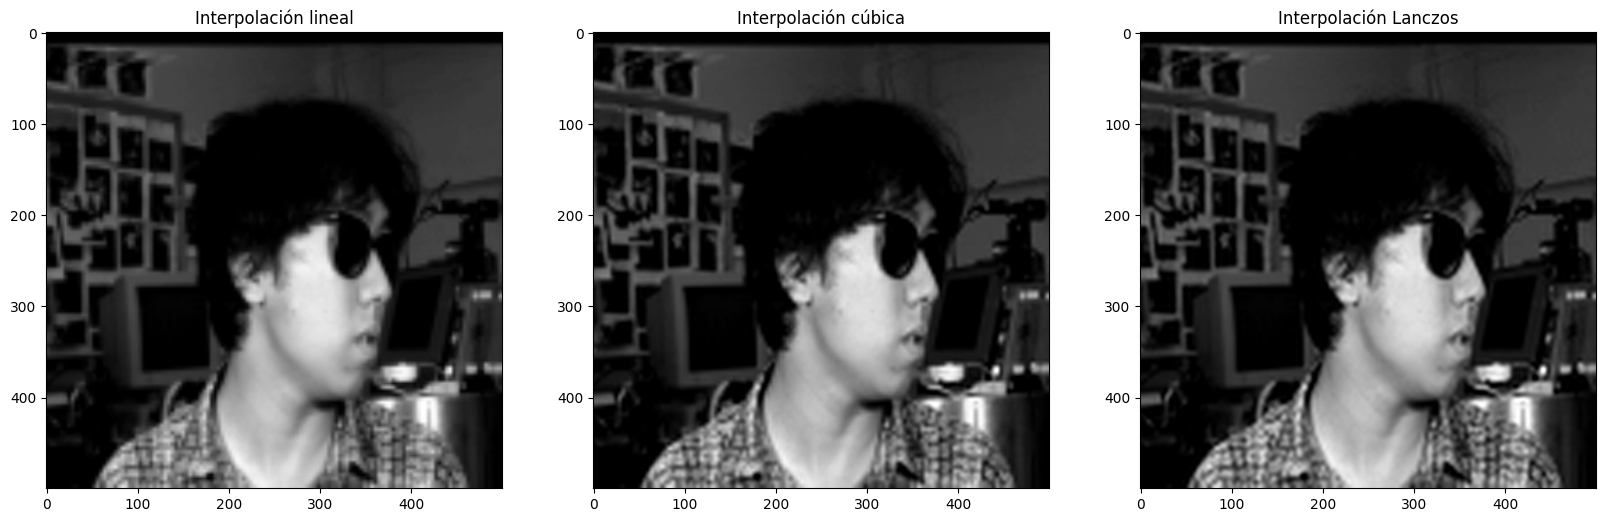

In [115]:
#Se grafican los resultados y elegimos el mejor metodo
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].imshow(high_res_img_linear, cmap='gray')
ax[0].set_title('Interpolación lineal')
ax[1].imshow(high_res_img_cubic, cmap='gray')
ax[1].set_title('Interpolación cúbica')
ax[2].imshow(high_res_img_lanc, cmap='gray')
ax[2].set_title('Interpolación Lanczos')
plt.show()


### Al observar los resultados vemos que la interpolacion cubica y de Lanczos no difieren mucho en calidad, mientras que en la interpolacion lineal se ve la menor calidad 

## 1.2 Filtro de alta frecuencia para resaltar detalles finos (bordes)

In [116]:
#Se establece un kernel con valor central mayor que el resto para resaltar los bordes
kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
sharpened_img_linear = cv2.filter2D(high_res_img_linear, -1, kernel)
sharpened_img_cubic = cv2.filter2D(high_res_img_cubic, -1, kernel)
sharpened_img_lanc = cv2.filter2D(high_res_img_lanc, -1, kernel)

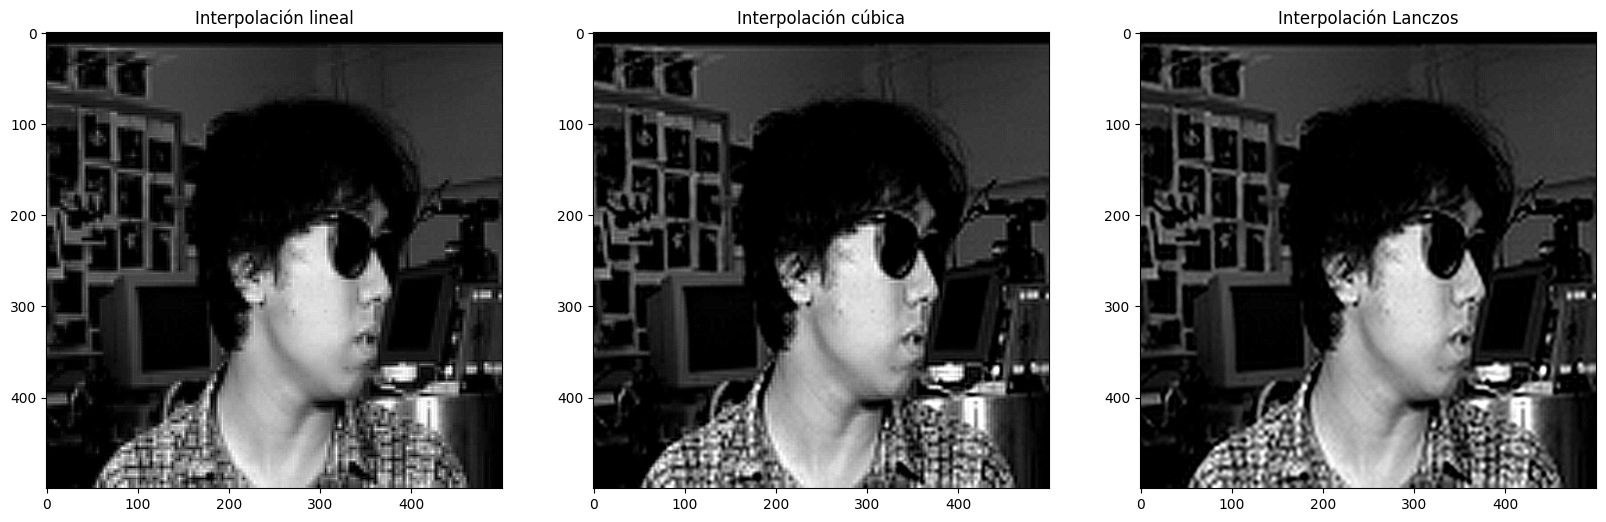

In [117]:
#Se grafican los resultados y elegimos el mejor metodo
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].imshow(sharpened_img_linear, cmap='gray')
ax[0].set_title('Interpolación lineal')
ax[1].imshow(sharpened_img_cubic, cmap='gray')
ax[1].set_title('Interpolación cúbica')
ax[2].imshow(sharpened_img_lanc, cmap='gray')
ax[2].set_title('Interpolación Lanczos')
plt.show()

### Elegimos la interpolazion cubica sobre las demas debido a su buen desempeño y bajo coste computacional

## 1.3 Expansion del historagrama

In [ ]:
matriz = np.ones((720,720), dtype=np.uint8)*180

In [109]:
imagen_modificada = cv2.add(sharpened_img_linear, matriz)

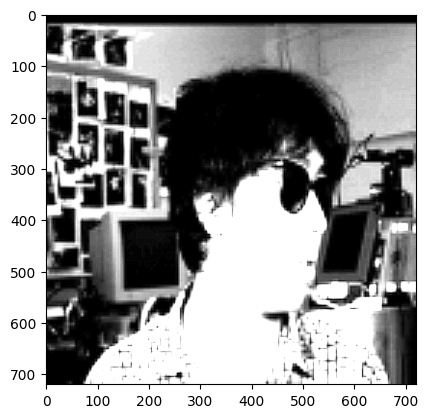

In [110]:
plt.imshow(imagen_modificada, cmap='gray')

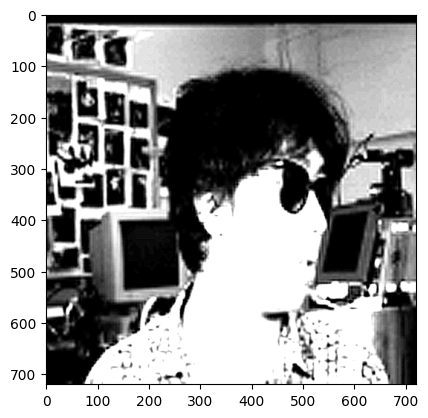

In [108]:
plt.imshow(imagen_modificada, cmap='gray')

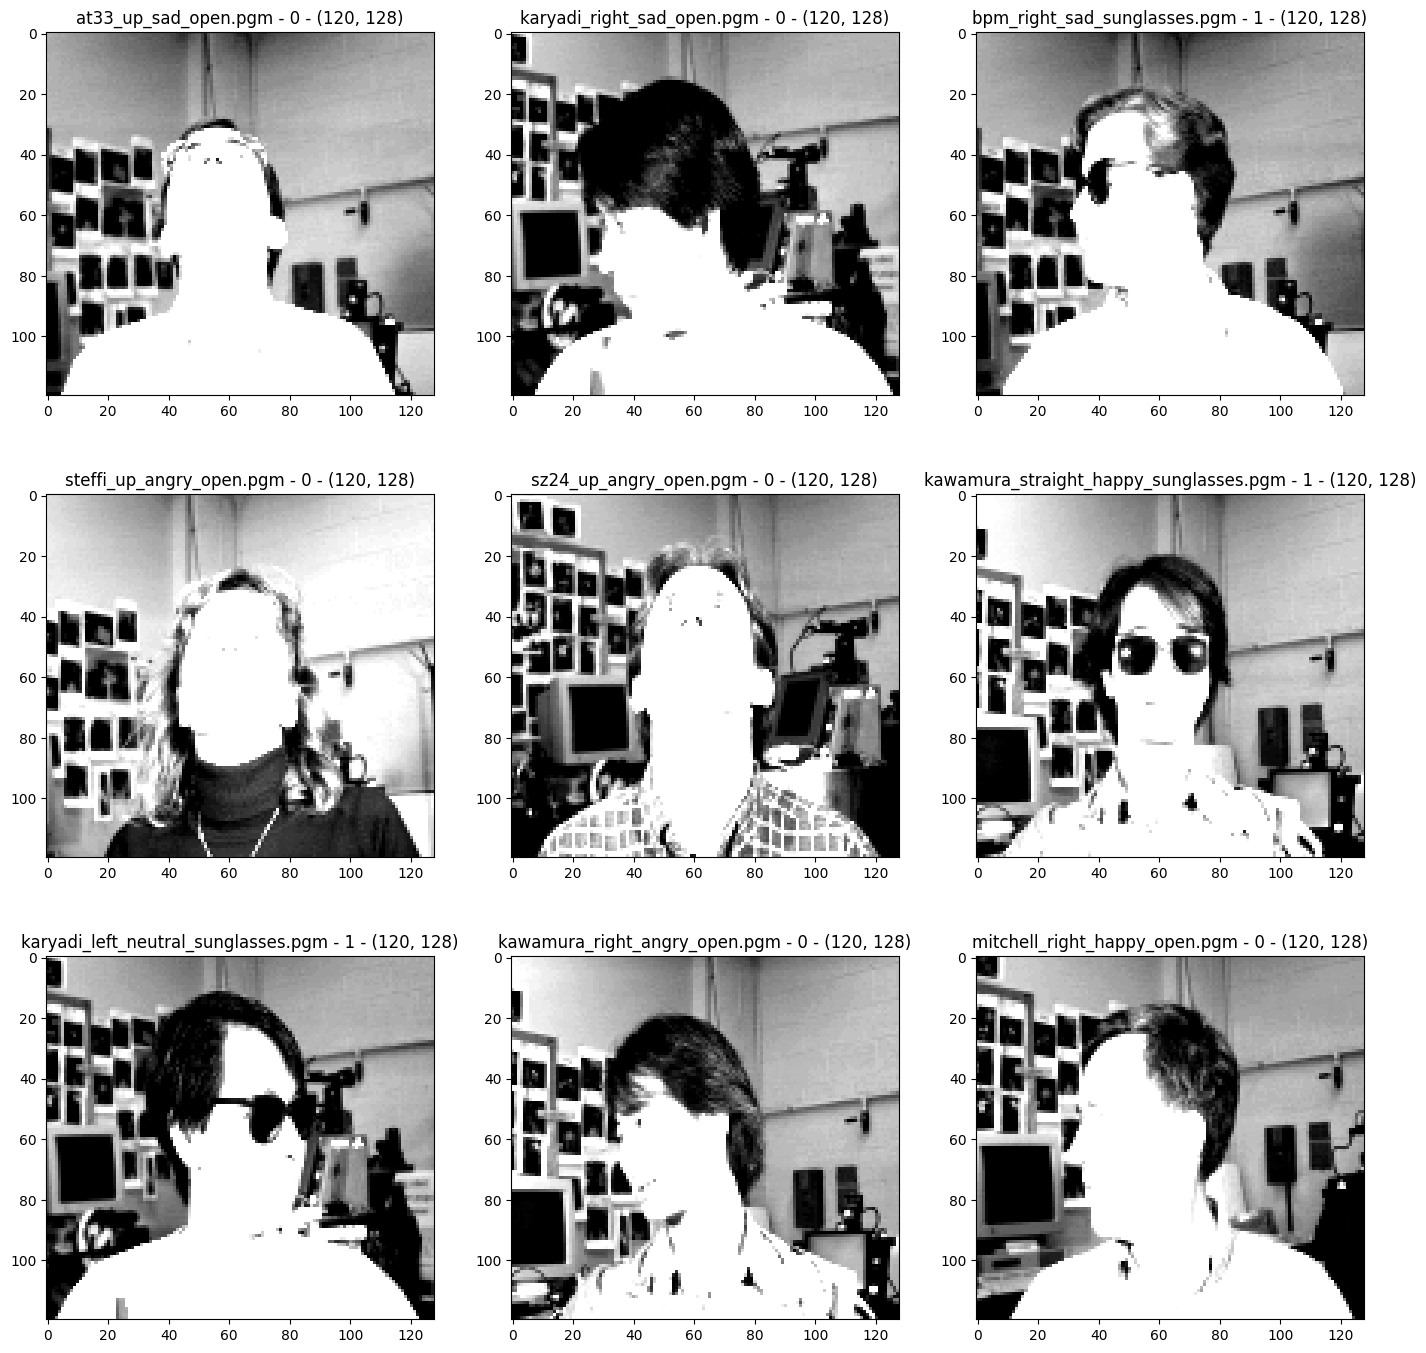

In [56]:
fig, ax = plt.subplots(3,3 ,figsize=(17,17))
matriz = np.ones(img.shape, dtype=np.uint8)*180 
for i in ax.flatten():
  nombre, etiqueta = df.sample().values[0]
  img = cv2.imread(f'imagenes/{nombre}', cv2.IMREAD_GRAYSCALE)
  imagen_modificada = cv2.add(img, matriz)
  i.imshow(imagen_modificada, cmap='gray')
  i.title.set_text(f'{nombre} - {etiqueta} - {img.shape}')